In [1]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology
import imageio
from myfunc import clip_background,cv2plot,set_borders_zero,resize_by_ratio,morph_line
%matplotlib inline

In [2]:
figsize = 50
alpha=0.5

In [3]:
# draw ellipse
import math
def ellipselattice(cx, cy, a, b, theta):
    res = []
    myborder_res = []
    at = a * math.sin(theta)
    bt = b * math.cos(theta)
    Fi = math.atan2(at, bt)
    M = math.hypot(at, bt)
    ta = math.pi/2 - Fi
    tb = -math.pi/2 - Fi
    y0 = at * math.cos(ta) + bt *math.sin(ta)
    y1 = at * math.cos(tb) + bt *math.sin(tb)
    y0, y1 = math.ceil(cy + min(y0, y1)), math.floor(cy + max(y0, y1))
    for y  in range(y0, y1+1):
        t1 = math.asin(y / M) - Fi
        t2 = math.pi - math.asin(y / M) - Fi
        x1 = a * math.cos(t1) * math.cos(theta) - b* math.sin(t1) * math.sin(theta)
        x2 = a * math.cos(t2) * math.cos(theta) - b* math.sin(t2) * math.sin(theta)
        x1, x2 = math.ceil(cx + min(x1, x2)), math.floor(cx + max(x1, x2))
        line = [(x, y) for x in range(x1, x2 + 1)]
        myborder = [(x1,y),(x2,y)]
        res.append(line)
        myborder_res.append(myborder)
    return res,myborder_res

# ellipselattice(0, 0, 4, 3, math.pi)

### generate fake target space (location_3d) & epi (border_3d)

In [4]:
xmax = 30
ymax = 60
ymid = int(ymax/2)
print(xmax,ymax,ymid)

30 60 30


In [5]:
location_3d = []
border_3d = []
loop = 10
z_distance = 1
for i in range(loop):
    slide = []
    slide_border = []
    a = int(xmax/2) - i*1.5
    b = int(ymax/2) - i*2
    ellipse,ellipse_boder = ellipselattice(0, 0, a, b, math.pi)
    # ellipse shape-------------------------------------------------
    for item in ellipse:
        for subitem in item:
            slide.append((subitem[0],subitem[1],i*z_distance))
            slide.append((subitem[0],subitem[1],-i*z_distance))
    slide = np.asarray(slide)
    if i==0:
        slide_minx = min(slide[:,0])
        slide_miny = min(slide[:,1])
    slide[:,0] = slide[:,0]-slide_minx
    slide[:,1] = slide[:,1]-slide_miny    
    slide[:,2] = slide[:,2]+z_distance*(loop-1)
    location_3d.append(slide)
        
     

    # ellipse border additional-------------------------------------------------
    slide_xmin = np.min(slide[:,0])
    slide_xmax = np.max(slide[:,0])
    slide_ymin = np.min(slide[:,1])
    slide_ymax = np.max(slide[:,1])
   
    marker1 = set(np.argwhere(slide[:,0]==slide_xmin ).squeeze())
    marker2 = set(np.argwhere(slide[:,0]==slide_xmax ).squeeze())
    marker3 = set(np.argwhere(slide[:,1]==slide_ymin ).squeeze())
    marker4 = set(np.argwhere(slide[:,1]==slide_ymax ).squeeze())
    marker_all = marker1 | marker2 | marker3 | marker4
    marker_all = list(marker_all)
    
    additional_slide_border = slide[marker_all]
    border_3d.append(additional_slide_border)
   
    # ellipse border-------------------------------------------------
    for item in ellipse_boder:
        for subitem in item:
            slide_border.append((subitem[0],subitem[1],i*z_distance))
            if i!=0:
                slide_border.append((subitem[0],subitem[1],-i*z_distance))
    slide_border = np.asarray(slide_border)
    slide_border[:,0] = slide_border[:,0]-slide_minx
    slide_border[:,1] = slide_border[:,1]-slide_miny    
    slide_border[:,2] = slide_border[:,2]+z_distance*(loop-1)
    border_3d.append(slide_border)

In [6]:
additional_slide_border[:6]

array([[15, 18, 18],
       [15, 18,  0],
       [14, 21, 18],
       [14, 21,  0],
       [16, 21, 18],
       [16, 21,  0]])

In [7]:
target_loaction_3d = []
border_location_3d = []
for item in location_3d:
    for subitem in item:
        target_loaction_3d.append(subitem)
target_loaction_3d = np.asarray(target_loaction_3d)

for item in border_3d:
    for subitem in item:
        border_location_3d.append(subitem)
        
border_location_3d = np.asarray(border_location_3d)

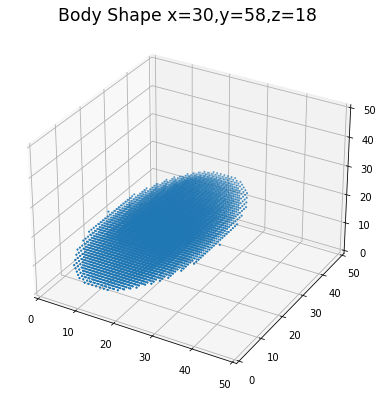

In [8]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.set_xlim([0,figsize])
ax.set_ylim([0,figsize])
ax.set_zlim([0,figsize])
x = target_loaction_3d[:,0]
y = target_loaction_3d[:,1]
z = target_loaction_3d[:,2]
ax.scatter(x,y,z,s=1)
plt.title('Body Shape x={},y={},z={}'.format(np.max(target_loaction_3d[:,0]),
                                             np.max(target_loaction_3d[:,1]),
                                             np.max(target_loaction_3d[:,2])),
                                             fontsize = 'xx-large')
plt.show()

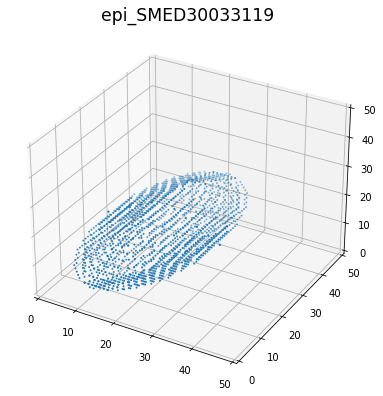

In [9]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.set_xlim([0,figsize])
ax.set_ylim([0,figsize])
ax.set_zlim([0,figsize])
x = border_location_3d[:,0]
y = border_location_3d[:,1]
z = border_location_3d[:,2]
ax.scatter(x,y,z,s=1)
plt.title('epi_SMED30033119',fontsize = 'xx-large')
plt.show()

In [10]:
print(target_loaction_3d.shape[0])

12346


In [11]:
zmax = np.max(target_loaction_3d[:,2])
zmin = np.min(target_loaction_3d[:,2])
print(zmax,zmin)

18 0


In [12]:
epi_atlas = np.zeros((target_loaction_3d.shape[0],1))
for i in range(target_loaction_3d.shape[0]):
    if i%2000 ==0:
        print(i)
    query = target_loaction_3d[i]
    if query[2]==zmax or query[2]==zmin:
        epi_atlas[i] = 1
        continue
    for item in border_location_3d:
        try:
            if np.all(query == item):
                epi_atlas[i] = 1
                break
        except:
            print('err')

print(sum(epi_atlas),target_loaction_3d.shape[0],border_location_3d.shape[0])

0
2000
4000
6000
8000
10000
12000
[1770.] 12346 2110


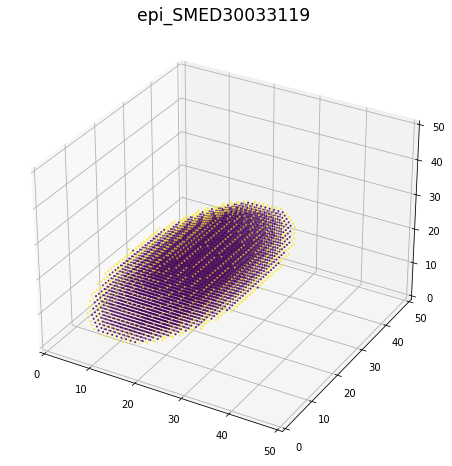

In [13]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlim([0,figsize])
ax.set_ylim([0,figsize])
ax.set_zlim([0,figsize])
x = target_loaction_3d[:,0]
y = target_loaction_3d[:,1]
z = target_loaction_3d[:,2]
ax.scatter(x,y,z,c=epi_atlas,s=1,alpha=alpha)
plt.title('epi_SMED30033119',fontsize = 'xx-large')
plt.show()

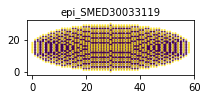

In [14]:
plt.figure(figsize=(3,1))
plt.scatter(target_loaction_3d[:, 1], target_loaction_3d[:, 0],c=epi_atlas,s=1,alpha=alpha)
plt.title('epi_SMED30033119',fontsize = 'medium')
plt.xlim([-2,60])
plt.ylim([-2,32])
plt.show()

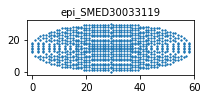

array([1770.])

In [15]:
epi_loc = np.where(epi_atlas.squeeze()!=0)
plt.figure(figsize=(3,1))
plt.scatter(target_loaction_3d[epi_loc, 1], target_loaction_3d[epi_loc, 0],s=1)
plt.title('epi_SMED30033119',fontsize = 'medium')
plt.xlim([-2,60])
plt.ylim([-2,32])
plt.show()
sum(epi_atlas)

In [16]:
print(np.max(target_loaction_3d[:,0]),np.max(target_loaction_3d[:,1]))

30 58


In [17]:
np.save('raw/epi_33119_atlas',epi_atlas)
np.save('raw/fake_3d_tissue',target_loaction_3d)

### generate fake_??_4921

In [18]:
zmid = int(zmax/2)
zmid

9

In [19]:
mid_points = []
for i in range(target_loaction_3d.shape[0]):
    query = target_loaction_3d[i]
    if query[2]==zmid-1:  ### the slide next to the midslide
        mid_points.append(target_loaction_3d[i,0:2])   
mid_points = np.asarray(mid_points)
print(np.max(mid_points[:,0]),np.max(mid_points[:,1]),np.min(mid_points[:,0]),np.min(mid_points[:,1]))

28 56 2 2


In [20]:
old_loc = np.load('raw/myshape.npy')
old_atlas = pd.read_csv('raw/atlas.txt',sep='\t')
old_gene = old_atlas['SMED30004921'].to_numpy()
old_gene_points = old_loc[np.argwhere(old_gene!=0)].squeeze()
print(np.max(old_loc[:,0]),np.max(old_loc[:,1]))

174 478


In [21]:
axes_scale_0 = (np.max(mid_points[:,0])-np.min(mid_points[:,0]))/np.max(old_loc[:,0])
axes_scale_1 = (np.max(mid_points[:,1])-np.min(mid_points[:,1]))/np.max(old_loc[:,1])

old_gene_points[:,0] = [int(i*axes_scale_0+2) for i in old_gene_points[:,0] if int(i*axes_scale_0)>0]
old_gene_points[:,1] = [int(i*axes_scale_1+4)for i in old_gene_points[:,1] if int(i*axes_scale_1)>0] #### ....
print(np.max(old_gene_points[:,0]),np.max(old_gene_points[:,1]),np.min(old_gene_points[:,0]),np.min(old_gene_points[:,1]))

22 53 5 11


In [22]:
len(old_gene_points[:,0])

5792

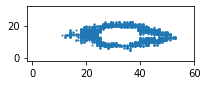

In [23]:
plt.figure(figsize=(3,1))
plt.scatter(old_gene_points[:,1],old_gene_points[:,0],s=1)
plt.xlim([-2,60])
plt.ylim([-2,32])
plt.show()

In [24]:
inner_atlas = np.zeros((target_loaction_3d.shape[0],1))

for i in range(target_loaction_3d.shape[0]):
    if i%2000 ==0:
        print(i)    
    query = target_loaction_3d[i]
    if query[2]!=zmid:
        if query[2]!=(zmid-1):
            if query[2]!=(zmid+1):
                continue
    for item in old_gene_points:
        try:
            if np.all(query[0:2] == item):
                inner_atlas[i] = 1                   
                break
        except:
            print('err')     
print(sum(inner_atlas),target_loaction_3d.shape[0],old_gene_points.shape)

0
2000
4000
6000
8000
10000
12000
[1248.] 12346 (5792, 2)


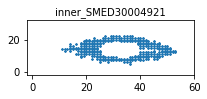

array([1248.])

In [25]:
inner_loc = np.where(inner_atlas.squeeze()!=0)
plt.figure(figsize=(3,1))
plt.scatter(target_loaction_3d[inner_loc, 1], target_loaction_3d[inner_loc, 0],s=1)
plt.title('inner_SMED30004921',fontsize = 'medium')
plt.xlim([-2,60])
plt.ylim([-2,32])
plt.show()
sum(inner_atlas)

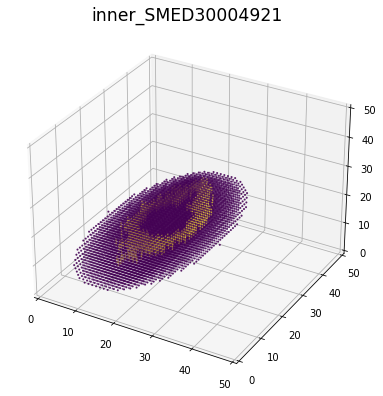

In [26]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.set_xlim([0,figsize])
ax.set_ylim([0,figsize])
ax.set_zlim([0,figsize])
x = target_loaction_3d[:,0]
y = target_loaction_3d[:,1]
z = target_loaction_3d[:,2]
ax.scatter(x,y,z,c=inner_atlas,s=1,alpha=alpha)
plt.title('inner_SMED30004921',fontsize = 'xx-large')
plt.show()

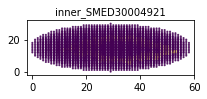

In [27]:
plt.figure(figsize=(3,1))
plt.scatter(target_loaction_3d[:, 1], target_loaction_3d[:, 0],c=inner_atlas,s=1,alpha=alpha)
plt.title('inner_SMED30004921',fontsize = 'medium')
plt.xlim([-2,60])
plt.ylim([-2,32])
plt.show()

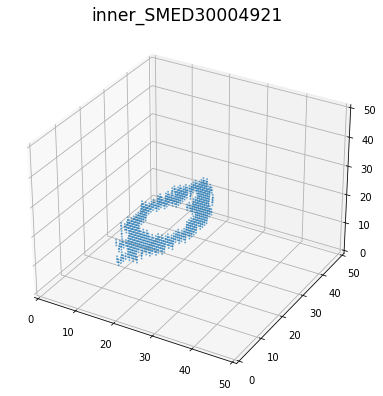

22 5 53 11


In [28]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.set_xlim([0,figsize])
ax.set_ylim([0,figsize])
ax.set_zlim([0,figsize])
x = target_loaction_3d[inner_loc,0]
y = target_loaction_3d[inner_loc,1]
z = target_loaction_3d[inner_loc,2]
ax.scatter(x,y,z,s=1,alpha=alpha)
plt.title('inner_SMED30004921',fontsize = 'xx-large')
plt.show()
print(np.max(x),np.min(x),np.max(y),np.min(y))

In [29]:
np.save('raw/ukn_04921_atlas',inner_atlas)